# TASK -2

## Problem Statement
In modern urban planning, the efficient design of road networks is crucial for fostering
connectivity and sustainable development. Night-time satellite imagery offers a unique
perspective, with illuminated areas often indicative of urban centers. In this task, I have to
develop an algorithm to extract the cities from this satellite image.


### Locating and Clustering using K MeansFirst we need to convert the image to numpy array yand weu should be capable of pinpointing
the coordinates corresponding to the lights. Subsequently, clustering these points can aid in
identifying the cities depicted in the provided imageWe
You need to implement the K Means Algorithmouryour own from scratch

#### IDEA OF APPROACH ::
1. Initialize K cluster centroids randomly
2. Repeat until convergence:
a. Assign each data point to the nearest centroid
b. Recompute the centroids as the mean of the data points assigned to each
centroid
c. Check for convergence criteria (e.g., small change in centroids or fixed number
of iterations)
3. Return the final centroids and cluster assignmentst.

**First Individual function will be made then will be fused in one function to give final output**

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
def convert_to_grayscale(image_path):     ## this is function which take an image and return the image in its grayscale form
    # Open the image
    image = Image.open(image_path)
    
    # Convert the image to grayscale
    grayscale_image = image.convert('L')
    
    return grayscale_image


image_path = 'D:/spark4AI/taskKDAG/1.png'
# Open the image using Pillow
img = Image.open(image_path)            ## This image may not be a 2 D array so converting it into 2d grayscale image array
img= convert_to_grayscale('D:/spark4AI/taskKDAG/1.png')

imgarr= np.array(img,dtype=np.int16)    ## converting to numpy array
print(imgarr)                           ##printing array

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
from dataclasses import dataclass   

@dataclass
class Point:                 ## making a data class point which contains integer x and y as co-ordinates of point
    x: int                   ## later will be used to hold k centroid list
    y: int

# Creating instances of the data class
p1 = Point(10, 20)
p2 = Point(30, 40)

print(p1)  # Output: Point(x=10, y=20)
print(p2)  # Output: Point(x=30, y=40)

# Accessing fields
print(p1.x, p1.y)  # Output: 10 20


Point(x=10, y=20)
Point(x=30, y=40)
10 20


In [4]:

from math import sqrt                          ## function to calculate distance between two point
                                               ## Take two arguments Points and returns float type distance between them

def calculate_distance(point1: Point, point2: Point) -> float:
    """Calculate the Euclidean distance between two points."""
    return sqrt((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2)

# Example usage
point1 = Point(3, 4)
point2 = Point(7, 1)
distance = calculate_distance(point1, point2)
print(f"The distance between {point1} and {point2} is {distance}")

The distance between Point(x=3, y=4) and Point(x=7, y=1) is 5.0






**In the array we need not use all cells for clustering , while implementing k-means we need to map only lighted cell to k centroids not the dark cell so we make function exclude dark which assign cell as -1 which has intensity value less than 255/2(considered dark) and rest cell as 0
so that we can identify which cells to be maped and which not**.

In [5]:
def excludedark(df):                         
                                             
     for i in range(df.shape[0]):
       for j in range(df.shape[1]):
          if(df[i][j]<(255/2)):
             df[i][j]=-1
          else:
            df[i][j]=0
              
     return df 


**For K means algo we need one initial random guess of centroid . So we make a function which take 2D array (with Dark - Light cells seggregated by -1 and 0 ) and returns the list of K Points among Lighted cells which can be used as initial guess of centroids**. 

In [6]:
 def random_k_centroid(df,k):          
     randomselection_list=[]
     for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if(df[i][j]!=-1):
                randomselection_list.append(Point(i,j))
           
           
     return random.sample(randomselection_list,k)  

**Now we have random k centroid and Our 2D array Now we need to map lighted cells to the Centroid which is Closest to it**.

**We do mapping by assigning cell the value of index of that centroid which is closest to it in the list of centroid**. 

In [7]:
def clustering(df, centroid_list, k):
  #  cluster_assignments = {} 
    
    for i in range(df.shape[0]):  # i varies over total rows
        for j in range(df.shape[1]): # j varies over total columns
            if(df[i][j]!=-1):  ## do mapping if cell is not dark
               closest_cluster = None
               dismin = calculate_distance(Point(0, 0), Point(df.shape[0], df.shape[1]))  # Assuming Point represents coordinates (0, 0) to (63, 63)
               for l in range(k): # l varies over total number of clusters 0 to k-1
                   distance = calculate_distance(Point(i, j), centroid_list[l])
                   if (distance <= dismin):
                      dismin = distance
                      closest_cluster = l          # index of the centroid point which keeps updating if other centroid found closer
               df[i][j]= closest_cluster           ## finally closest one is assigned to that cell 
                  
    return df

# this function now changes values at that index only

**Now our array lighted cell got assigned to some value after clustering function**..

**Now lets make a function to calcute the new centroid list by taking mean of previous clusters**.

In [8]:
def centroidlist(workingarray,k):
    centroidlistnew=[]
    for m in range(k):     # m ranges o to k-1
       xsum=0              # for a particular cluster x sum holds sum of all x cordinates of cell having assigned value of that cluster
       ysum=0              # corresponding for y
       num=0
       for i in range(workingarray.shape[0]):
            for j in range(workingarray.shape[1]):
                 if(workingarray[i][j]==m ):
                    xsum=xsum+i
                    ysum=ysum+j
                    num=num+1    ## num for keeping the track how many total points in the cluster . 
                
        
       centroidlistnew.append(Point(int(xsum/num),int(ysum/num)))   # append The point x,y which is average of all x and y in that cluster
                        
    return centroidlistnew                          
               

**Now all the required functions are ready. Lets fuse them in one now**.

In [9]:


def Kmeanscluster( img_path,k): ## take path of image and k as parameter
    
    img= convert_to_grayscale(img_path) # covert image in grayscale
    imgarr= np.array(img,dtype=np.int16)  # covert grayscale image to numpy array
    imgarr= excludedark(imgarr)         # seggregate dark and lighted cell
    initialcentroid= random_k_centroid(imgarr,k)   ## generate initial centroid list
    centroid=initialcentroid                    # centroid to hold updated centroid list
    prevcentroid=[]                             # prevcentroid to hold list of previous iterations centroid list to compare it
                                                # with new one so that we stop when convergence is reached i.e when they become equal.
    
    while(centroid!= prevcentroid):     # condition until convergence if reached 
        imgarr= clustering(imgarr,centroid,k) # do assign cells the value by clustering
        prevcentroid=centroid          # update prevcentroid list
        centroid= centroidlist(imgarr,k)   # update new centroid list

    return centroid                     # finally returning the final centroid list.
        


## Now lets make a function that plots the scatter plot of the image with the positions of centroid and tell the distance between the cities.

In [28]:
def plotcity(image_path, k):
    # Assume Kmeanscluster, convert_to_grayscale, excludedark, and clusturing are defined elsewhere
    centroid = Kmeanscluster(image_path, k)
    im = convert_to_grayscale(image_path)  # Convert image to grayscale
    imarr = np.array(im, dtype=np.int16)  # Convert grayscale image to numpy array
    imarr = excludedark(imarr)  # Segregate dark and lighted cells
    imarr = clustering(imarr, centroid, k)
    colors = ["r", "g", "b", "y"]

    fig, ax = plt.subplots()  # Create a figure and axes object
    X_centroid=[]
    Y_centroid=[]
    for i in range(k):
        X = []
        Y = []
        X_centroid.append(centroid[i].x)
        Y_centroid.append(centroid[i].y)
        
        for row in range(imgarr.shape[0]):
            for column in range(imarr.shape[1]):
                if imarr[row][column] == i:
                    X.append(row)
                    Y.append(column)
        
        # Create the scatter plot for the current cluster
        ax.scatter(Y, X, c=colors[i % len(colors)], label=f'CITY {i+1}')

    # Shift the x-axis to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.invert_yaxis()

    # Titles and labels
    ax.set_title('City')
    ax.set_xlabel('Column')
    ax.set_ylabel('Rows')
    ax.set_xticks(np.arange(0, 65, step=5))  # Adjust step for readability
    ax.set_yticks(np.arange(0, 65, step=5))  # Adjust step for readability
    ax.scatter(Y_centroid,X_centroid,c="black",s=250,marker=".",label="Centre of city")
    
    plt.legend()
    
    for i in range(k):
        for j in range(i+1,k):
            plt.plot([Y_centroid[i],Y_centroid[j]],[X_centroid[i],X_centroid[j]],color="#525863")

    for i in range(k):
        for j in range(i+1,k):
            print(f" Distance between city or cluster {i+1} and {j+1} is :{ calculate_distance(centroid[i],centroid[j]) }" )
    

    
    
    

# NOW EVERYTHING IS READY LETS BRING IMAGES INTO THE GAME

#### Note :: If city appears abrupt please run that image cell once again.

## IMAGE 1

 Distance between city or cluster 1 and 2 is :24.515301344262525
 Distance between city or cluster 1 and 3 is :44.27188724235731
 Distance between city or cluster 2 and 3 is :26.1725046566048


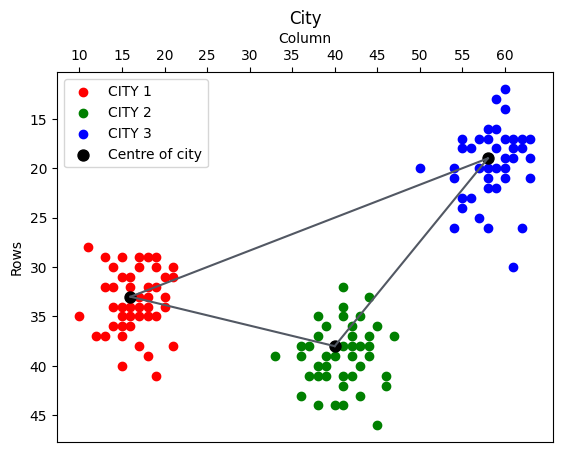

In [29]:
plotcity('D:/spark4AI/taskKDAG/1.png',3)

## IMAGE 2

 Distance between city or cluster 1 and 2 is :22.47220505424423
 Distance between city or cluster 1 and 3 is :22.80350850198276
 Distance between city or cluster 2 and 3 is :18.24828759089466


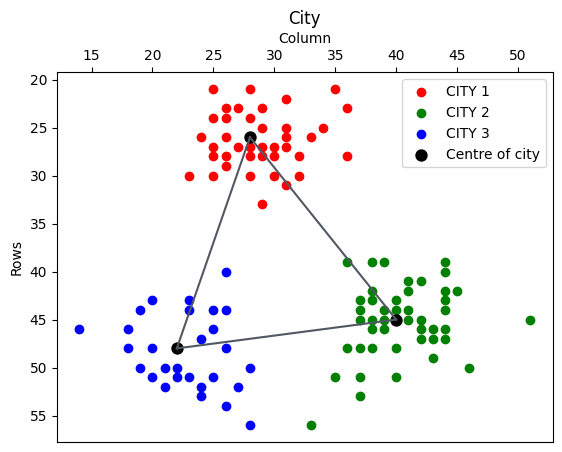

In [12]:
plotcity("D:/spark4AI/taskKDAG/2.png",3)

## IMAGE 3

 Distance between city or cluster 1 and 2 is :40.0
 Distance between city or cluster 1 and 3 is :57.28001396647874
 Distance between city or cluster 1 and 4 is :40.0
 Distance between city or cluster 2 and 3 is :40.01249804748511
 Distance between city or cluster 2 and 4 is :56.568542494923804
 Distance between city or cluster 3 and 4 is :41.0


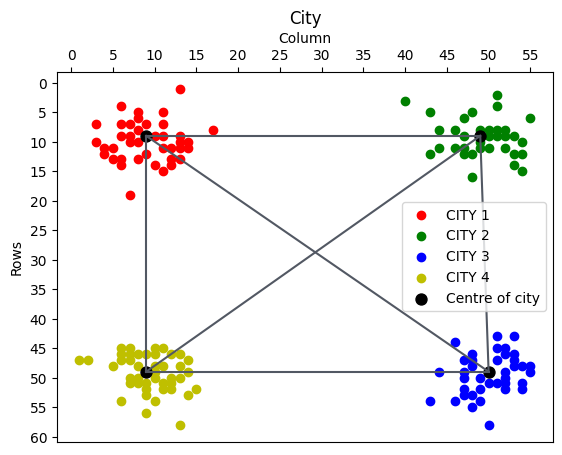

In [13]:
plotcity("D:/spark4AI/taskKDAG/3.png",4)

## IMAGE 4

 Distance between city or cluster 1 and 2 is :40.24922359499622


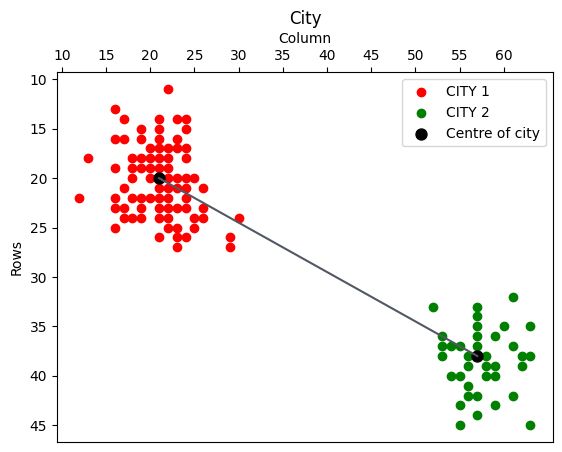

In [14]:
plotcity("D:/spark4AI/taskKDAG/4.png",2)

# ELBOW GRAPH

In [30]:
def elbowgraph(img_path):
    kvalue=[]
    WCSS=[]
    imgg = convert_to_grayscale(image_path)
    imggarr = np.array(img, dtype=np.int16)
    imggarr = excludedark(imggarr)
    
    for i in range(10):
        sqsum=0
        k=i+1
        kvalue.append(k)
        centroid = Kmeanscluster(image_path, k)
        imggarr = clustering(imggarr, centroid, k)

        for j in range(k):
            for row in range(imggarr.shape[0]):
                for column in range(imggarr.shape[1]):
                    if(imggarr[row][column]== j):
                        sqsum= sqsum+ (int( calculate_distance(centroid[j],Point(row,column))**2) )
        WCSS.append(sqsum)  

    plt.plot(kvalue,WCSS)
    plt.xlabel("K-value")
    plt.ylabel("WCSS value")
    plt.xticks(np.arange(0,11))
    plt.show()
            
        
            
                
            
        


        
        
    

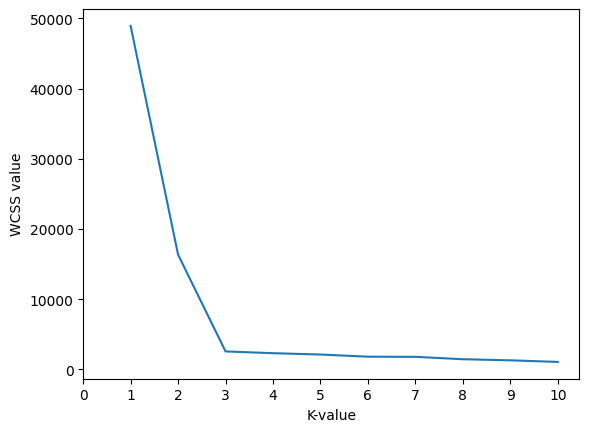

In [31]:
elbowgraph('D:/spark4AI/taskKDAG/1.png')   ## for imgage 1

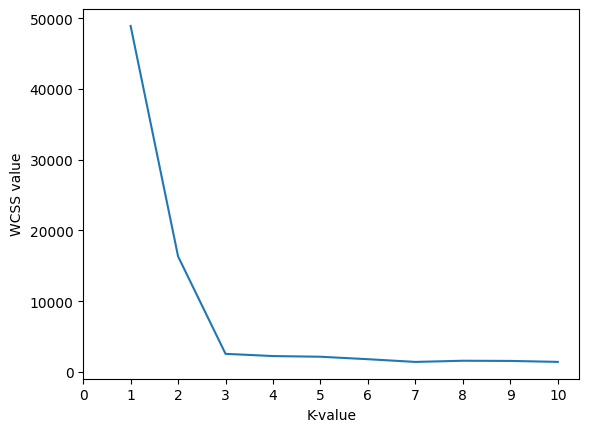

In [33]:
elbowgraph("D:/spark4AI/taskKDAG/2.png")   ## for imgage 2

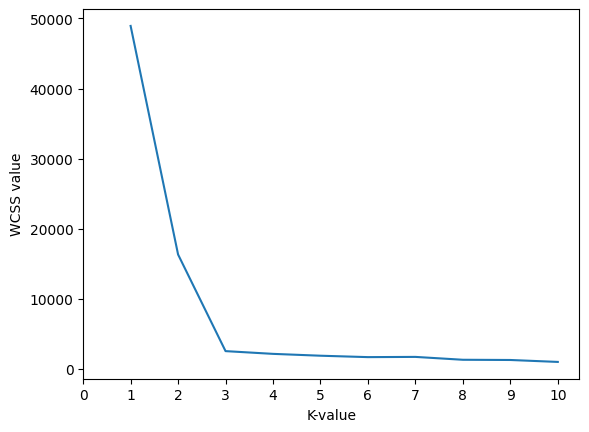

In [34]:
elbowgraph("D:/spark4AI/taskKDAG/3.png")   ## for imgage 3

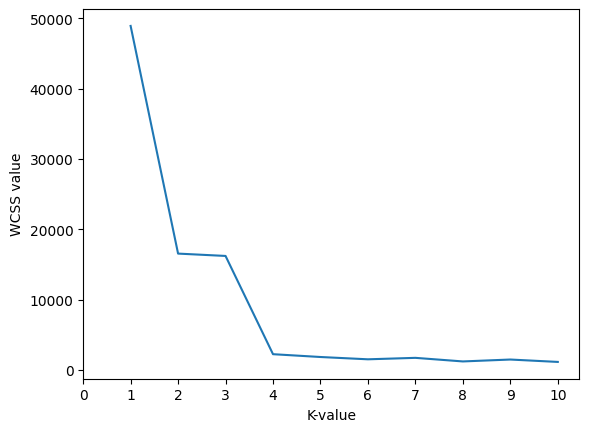

In [35]:
elbowgraph("D:/spark4AI/taskKDAG/4.png")   ## for imgage 4